In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
apple = sio.loadmat('matlab.mat')

In [32]:
apple_data = apple['ans']
apple_data = np.squeeze(apple_data)

In [111]:
train_data = apple_data[:-10]
test_data = apple_data[-10:]

In [112]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [113]:
train_input = torch.from_numpy(train_data_normalized).type(torch.Tensor).view(-1)

In [114]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        train_seq = train_seq.to(device)
        train_label = train_label.to(device)
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [115]:
train_inout_seq = create_inout_sequences(train_input, 5)

In [116]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [117]:
model = LSTM()
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [118]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [119]:
epochs = 500

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i % 100 == 0:
        print("Epoch ", i, "MSE: ", single_loss.item())

Epoch  0 MSE:  0.025571253150701523
Epoch  100 MSE:  0.0016435092547908425
Epoch  200 MSE:  0.0037324533332139254
Epoch  300 MSE:  0.000962505757343024
Epoch  400 MSE:  0.006183018907904625


In [120]:
test_inputs = train_input[-10:].tolist()
print(test_inputs)

[0.8689414262771606, 0.8836816549301147, 0.9059516787528992, 0.8953777551651001, 0.9327083230018616, 0.7694462537765503, 0.8101417422294617, 1.0, 0.9373547434806824, 0.943602979183197]


In [121]:
model.eval()

for i in range(10):
    seq = torch.FloatTensor(test_inputs[-39:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())

In [122]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[10:] ).reshape(-1, 1))
print(actual_predictions)

[[324.37030247]
 [322.35889618]
 [322.10915008]
 [328.99923634]
 [324.80206428]
 [321.56340059]
 [319.59957969]
 [319.89887175]
 [323.98160598]
 [325.49473286]]


In [123]:
x = np.arange(121, 131, 1)
print(x)

[121 122 123 124 125 126 127 128 129 130]


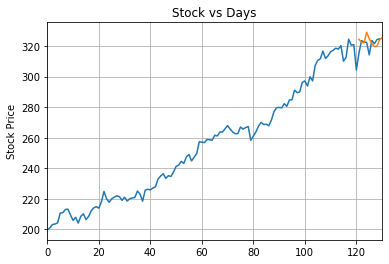

In [124]:
plt.title('Stock vs Days')
plt.ylabel('Stock Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(apple_data)
plt.plot(x,actual_predictions)
plt.show()